# 1006개의 데이터로 Transfer_Learning 하기

- Resnet 모델 사용 + imagenet 가중치 freeze
- 논문 모델의 FC layer를 수정하여 학습  
    (best_model_resnet_imagenet_256로 저장)
- 추후 resnet 모델 (imagenet 가중치) + FC layer(학습 가중치)를 진행
- 이때 Learning rate는 1e-5 정도로 학습  
    (Resnet_Reconstruction_model.h5)

## Step 1. 실험환경 set-up

#### 라이브러리 실행

In [1]:
from tensorflow.keras.models import Sequential, load_model

import os           
import numpy             as np  
import tensorflow        as tf
import matplotlib.pyplot as plt

#### 필요한 변수들 생성

In [2]:
IMAGE_SIZE = [1024, 1360]                  # 이미지 사이즈 변수
BATCH_SIZE = 32                            # BATCH_SIZE 변수
EPOCHS     = 150                           # EPOCH 크기 변수
AUTOTUNE   = tf.data.experimental.AUTOTUNE # 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수

#### GPU 사용 여부보기

In [3]:
gpus = tf.config.experimental.list_logical_devices("GPU")

if len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print(f"Running on multiple GPUs {[gpu.name for gpu in gpus]}")

elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy()
    print(f"Running on single GPU {gpus[0].name}")

else:
    strategy = tf.distribute.get_strategy()
    print("Running on CPU")

print(f"Number of accelerators: {strategy.num_replicas_in_sync}")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Step 2. 데이터 준비하기

먼저 아래의 링크에서 데이터를 다운 받을 것

https://drive.google.com/drive/folders/1Pi5qyX080zY2IdGT1TvvLraBO9DHBxJl?usp=sharing

받은 후 터미널 창에 아래의 명령어들을 차례로 입력

```
$ cd ~/Downloads && cp CellPin ~/aiffel
```

#### 데이터의 개수 확인

In [4]:
# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv("HOME"), "aiffel/CellPin")
print(ROOT_PATH)

# 각 데이터 불러오기
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + "/train/*/*"))
test_filenames  = tf.io.gfile.glob(str(ROOT_PATH + "/test/*/*"))
val_filenames   = tf.io.gfile.glob(str(ROOT_PATH + "/val/*/*"))

# 데이터 갯수 확인하기
print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

/workspace/storage/CellPin
782
104
126


#### train과 validation을 80:20으로 분할

In [5]:
# filenames = tf.io.gfile.glob(str(ROOT_PATH + '/train/*/*'))
# filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/val/*/*')))

# train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

# print(len(train_filenames))
# print(len(val_filenames))

#### train 데이터 안에 정상 이미지 수와 CPE 이미지 수

In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "normal" in filename])
print("NORMAL images count in training set: " + str(COUNT_NORMAL))

COUNT_CPE = len([filename for filename in train_filenames if "cpe" in filename])
print("CPE images count in training set: " + str(COUNT_CPE))

NORMAL images count in training set: 355
CPE images count in training set: 427


#### val 데이터 안에 정상 이미지 수와 CPE 이미지 수

In [7]:
COUNT_NORMAL = len([filename for filename in val_filenames if "normal" in filename])
print("NORMAL images count in training set: " + str(COUNT_NORMAL))

COUNT_CPE = len([filename for filename in val_filenames if "cpe" in filename])
print("CPE images count in training set: " + str(COUNT_CPE))

NORMAL images count in training set: 50
CPE images count in training set: 76


#### test 데이터 안에 정상 이미지 수와 CPE 이미지 수

In [8]:
COUNT_NORMAL = len([filename for filename in test_filenames if "normal" in filename])
print("NORMAL images count in training set: " + str(COUNT_NORMAL))

COUNT_CPE = len([filename for filename in test_filenames if "cpe" in filename])
print("CPE images count in training set: " + str(COUNT_CPE))

NORMAL images count in training set: 40
CPE images count in training set: 64


#### tf.data 인스턴스를 만들기

In [9]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

#### train data와 val data의 개수 확인

In [10]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 782
Validating images count: 126


#### 라벨 이름들 확인

In [11]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/train/*"))])
print(CLASS_NAMES)

['normal' 'cpe']


#### 라벨링 함수를 만들어 보기

In [12]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "cpe"

#### decode_img 함수와 process_path 함수를 만들기

In [13]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels = 1)
    
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
    
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    
    if label == True:
        label = ([0, 1])
    else:
        label = ([1, 0])
        
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    
    return img, label

#### train과 val에 함수들 적용해주기

In [14]:
train_ds = train_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)
val_ds   = val_list_ds.map(process_path,   num_parallel_calls = AUTOTUNE)

#### 전처리 함수 만들기 및 적용

In [16]:
def prepare_for_training(ds, shuffle_buffer_size = 1000):
    ds = ds.shuffle(buffer_size = shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size = AUTOTUNE)

    return ds


train_ds = prepare_for_training(train_ds)
val_ds   = prepare_for_training(val_ds)

#### Image shape를 변경 체크하기

In [17]:
for image, label in train_ds.take(1):
    print("Image shape :", image.numpy().shape)
    print("Label :",       label.numpy().shape)

Image shape:  (32, 256, 256, 3)
Label:  (32, 2)


#### test 데이터 셋도 만들어 보기 & 데이터의 갯수 확인

In [18]:
test_list_ds     = tf.data.Dataset.list_files(str(ROOT_PATH + "/test/*/*"))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds          = test_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)
test_ds          = test_ds.batch(BATCH_SIZE)
print(TEST_IMAGE_COUNT)

104


## Step 3. 데이터 시각화

#### 16개의 샘플 꺼내서 확인

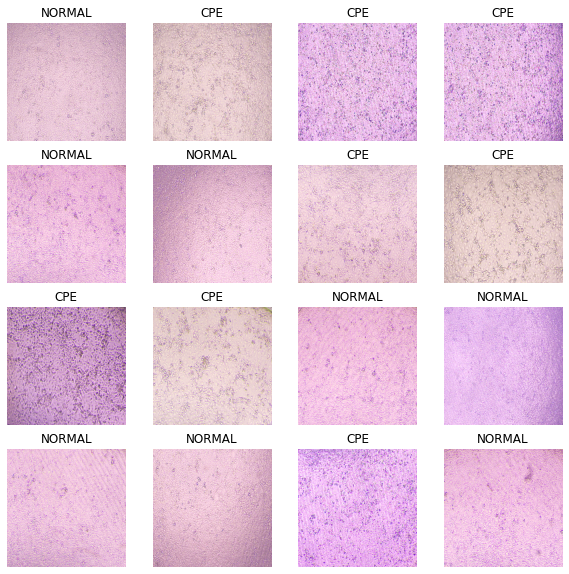

In [19]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize = (10,10))
    
    for n in range(16):
        ax = plt.subplot(4, 4, n + 1)
        plt.imshow(image_batch[n])
        
        if list(label_batch[n])[0].numpy() == 0:
            plt.title("CPE")
        else:
            plt.title("NORMAL")
        
        plt.axis("off")

        
show_batch(image_batch.numpy(), label_batch)

#### model building(ResNet, Freeze)

In [20]:
with strategy.scope():
    # resnet에서 분류기를 제외한 부분을 가중치 있는 상태로 가져오기
    resnet_layer = tf.keras.applications.ResNet152V2(include_top           = False,
                                                     weights               = "imagenet",
                                                     input_shape           = (256, 256, 3),
                                                     classes               = 2,
                                                     classifier_activation = "softmax")
    
    # 제거된 분류기 만들기
    fc_layer = [
        tf.keras.layers.GlobalMaxPool2D(),
        tf.keras.layers.Dense(2),
        tf.keras.layers.Activation('softmax')
    ]
    
    # 가중치 있는 레이어를 학습 불가능 상태로 만들기
    resnet_layer.trainable = False
    
    # 두 레이어를 합쳐서 모델 만들기
    resnet152 = tf.keras.models.Sequential([resnet_layer] + fc_layer)

234553344/234545216 [==============================] - 2s 0us/step


In [24]:
resnet152.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 8, 8, 2048)        58331648  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
_________________________________________________________________
activation (Activation)      (None, 2)                 0         
Total params: 58,335,746
Trainable params: 4,098
Non-trainable params: 58,331,648
_________________________________________________________________


## Step 4. 모델 훈련

#### GPU사용하여 model complie

In [27]:
with strategy.scope():
    METRICS = [
        "accuracy",
        tf.keras.metrics.Precision(name = "precision"),
        tf.keras.metrics.Recall(name    = "recall")
    ]
    
    resnet152.compile(
        optimizer = "adam",
        loss      = "binary_crossentropy",
        metrics   = METRICS
    )
    
    check_point = tf.keras.callbacks.ModelCheckpoint("best_model_resnet_imagenet_256.h5")

#### 모델 fitting

In [29]:
with strategy.scope():
    history = resnet152.fit(
        train_ds,
        steps_per_epoch  = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs           = EPOCHS,
        validation_data  = val_ds,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        callbacks        = [check_point]
    )

Epoch 1/150
24/24 [==============================] - 152s 3s/step - loss: 0.8101 - accuracy: 0.6698 - precision: 0.6698 - recall: 0.6698 - val_loss: 0.2855 - val_accuracy: 0.8958 - val_precision: 0.8958 - val_recall: 0.8958
Epoch 2/150
24/24 [==============================] - 66s 3s/step - loss: 0.2930 - accuracy: 0.8902 - precision: 0.8902 - recall: 0.8902 - val_loss: 0.2356 - val_accuracy: 0.9167 - val_precision: 0.9167 - val_recall: 0.9167
Epoch 3/150
24/24 [==============================] - 69s 3s/step - loss: 0.1932 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - val_loss: 0.2164 - val_accuracy: 0.9062 - val_precision: 0.9062 - val_recall: 0.9062
Epoch 4/150
24/24 [==============================] - 76s 3s/step - loss: 0.1552 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - val_loss: 0.1471 - val_accuracy: 0.9583 - val_precision: 0.9583 - val_recall: 0.9583
Epoch 5/150
24/24 [==============================] - 63s 3s/step - loss: 0.1316 - accuracy: 0.9523 - precis

Epoch 38/150
24/24 [==============================] - 63s 3s/step - loss: 0.0115 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1557 - val_accuracy: 0.9375 - val_precision: 0.9375 - val_recall: 0.9375
Epoch 39/150
24/24 [==============================] - 63s 3s/step - loss: 0.0106 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1426 - val_accuracy: 0.9375 - val_precision: 0.9375 - val_recall: 0.9375
Epoch 40/150
24/24 [==============================] - 63s 3s/step - loss: 0.0125 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1787 - val_accuracy: 0.9167 - val_precision: 0.9167 - val_recall: 0.9167
Epoch 41/150
24/24 [==============================] - 64s 3s/step - loss: 0.0100 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1214 - val_accuracy: 0.9479 - val_precision: 0.9479 - val_recall: 0.9479
Epoch 42/150
24/24 [==============================] - 64s 3s/step - loss: 0.0101 - accuracy: 1.0000 - pr

24/24 [==============================] - 64s 3s/step - loss: 0.0018 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1524 - val_accuracy: 0.9479 - val_precision: 0.9479 - val_recall: 0.9479
Epoch 111/150
24/24 [==============================] - 64s 3s/step - loss: 0.0017 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1364 - val_accuracy: 0.9479 - val_precision: 0.9479 - val_recall: 0.9479
Epoch 112/150
24/24 [==============================] - 64s 3s/step - loss: 0.0017 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2123 - val_accuracy: 0.9271 - val_precision: 0.9271 - val_recall: 0.9271
Epoch 113/150
24/24 [==============================] - 64s 3s/step - loss: 0.0016 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2113 - val_accuracy: 0.9167 - val_precision: 0.9167 - val_recall: 0.9167
Epoch 114/150
24/24 [==============================] - 64s 3s/step - loss: 0.0018 - accuracy: 1.0000 - precision: 

## Step 5. 결과 확인 및 시각화

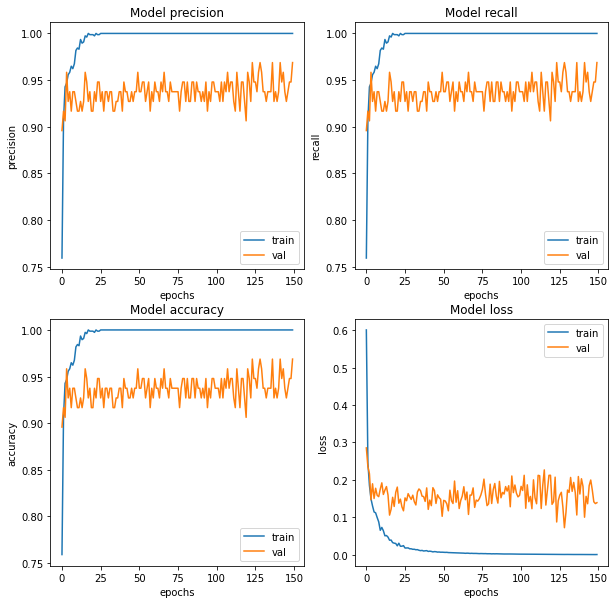

In [30]:
fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax      = ax.ravel()

for i, met in enumerate(["precision", "recall", "accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title(f"Model {met}")
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

## Step 6. 최종 Test dataset 검정하기

In [31]:
with strategy.scope():
    resnet152 = tf.keras.models.load_model("best_model_resnet_imagenet_256.h5")
    
    loss, acc, prec, rec = resnet152.evaluate(test_ds)

4/4 [==============================] - 39s 11s/step - loss: 0.1876 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327


In [ ]:
# unfreeze
with strategy.scope():
    resnet152.layers[0].trainable = True

In [34]:
resnet152.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 8, 8, 2048)        58331648  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
_________________________________________________________________
activation (Activation)      (None, 2)                 0         
Total params: 58,335,746
Trainable params: 58,192,002
Non-trainable params: 143,744
_________________________________________________________________


In [35]:
with strategy.scope():
    METRICS = [
        "accuracy",
        tf.keras.metrics.Precision(name = "precision"),
        tf.keras.metrics.Recall(name    = "recall")
    ]
    
    resnet152.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
        loss      = "binary_crossentropy",
        metrics   = METRICS
    )
    
    check_point = tf.keras.callbacks.ModelCheckpoint("Resnet_Reconstruction_model.h5")

In [37]:
with strategy.scope():
    history = resnet152.fit(
        train_ds,
        steps_per_epoch  = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs           = EPOCHS,
        validation_data  = val_ds,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        callbacks        = [check_point]
    )

Epoch 1/150
24/24 [==============================] - 181s 3s/step - loss: 4.8962 - accuracy: 0.7238 - precision: 0.7238 - recall: 0.7238 - val_loss: 53976397512704.0000 - val_accuracy: 0.6146 - val_precision: 0.6146 - val_recall: 0.6146
Epoch 2/150
24/24 [==============================] - 67s 3s/step - loss: 1.6805 - accuracy: 0.5705 - precision: 0.5705 - recall: 0.5705 - val_loss: 557012928.0000 - val_accuracy: 0.4062 - val_precision: 0.4062 - val_recall: 0.4062
Epoch 3/150
24/24 [==============================] - 70s 3s/step - loss: 1.1071 - accuracy: 0.5913 - precision: 0.5913 - recall: 0.5913 - val_loss: 15781917.0000 - val_accuracy: 0.3750 - val_precision: 0.3750 - val_recall: 0.3750
Epoch 4/150
24/24 [==============================] - 77s 3s/step - loss: 0.8519 - accuracy: 0.5554 - precision: 0.5554 - recall: 0.5554 - val_loss: 38.9685 - val_accuracy: 0.5417 - val_precision: 0.5417 - val_recall: 0.5417
Epoch 5/150
24/24 [==============================] - 64s 3s/step - loss: 0.700

Epoch 74/150
24/24 [==============================] - 64s 3s/step - loss: 0.1185 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - val_loss: 0.1829 - val_accuracy: 0.9375 - val_precision: 0.9375 - val_recall: 0.9375
Epoch 75/150
24/24 [==============================] - 64s 3s/step - loss: 0.1101 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - val_loss: 0.1724 - val_accuracy: 0.9479 - val_precision: 0.9479 - val_recall: 0.9479
Epoch 76/150
24/24 [==============================] - 65s 3s/step - loss: 0.1179 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - val_loss: 0.2266 - val_accuracy: 0.9167 - val_precision: 0.9167 - val_recall: 0.9167
Epoch 77/150
24/24 [==============================] - 65s 3s/step - loss: 0.0990 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - val_loss: 0.2317 - val_accuracy: 0.9062 - val_precision: 0.9062 - val_recall: 0.9062
Epoch 78/150
24/24 [==============================] - 64s 3s/step - loss: 0.1151 - accuracy: 0.9882 - pr

24/24 [==============================] - 63s 3s/step - loss: 0.0528 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - val_loss: 0.3734 - val_accuracy: 0.8542 - val_precision: 0.8542 - val_recall: 0.8542
Epoch 147/150
24/24 [==============================] - 64s 3s/step - loss: 0.0577 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - val_loss: 0.1950 - val_accuracy: 0.9375 - val_precision: 0.9375 - val_recall: 0.9375
Epoch 148/150
24/24 [==============================] - 64s 3s/step - loss: 0.0497 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - val_loss: 0.2732 - val_accuracy: 0.9167 - val_precision: 0.9167 - val_recall: 0.9167
Epoch 149/150
24/24 [==============================] - 64s 3s/step - loss: 0.0630 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - val_loss: 0.2048 - val_accuracy: 0.9375 - val_precision: 0.9375 - val_recall: 0.9375
Epoch 150/150
24/24 [==============================] - 64s 3s/step - loss: 0.0490 - accuracy: 0.9950 - precision: 

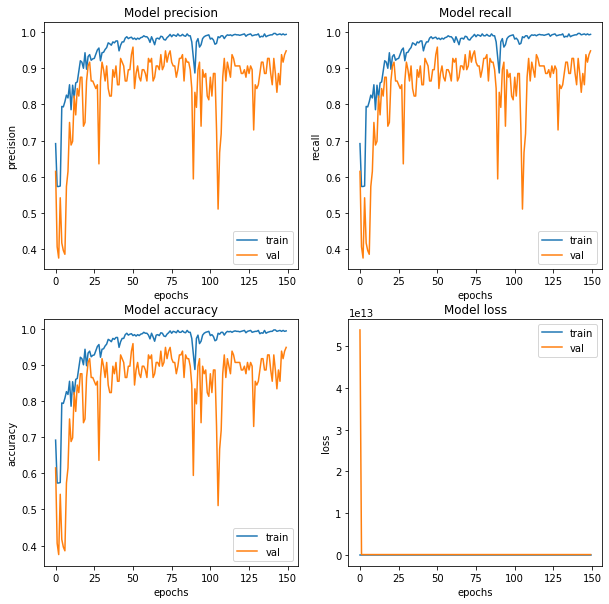

In [38]:
fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax      = ax.ravel()

for i, met in enumerate(["precision", "recall", "accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title(f"Model {met}")
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

In [39]:
with strategy.scope():
    resnet152 = tf.keras.models.load_model("Resnet_Reconstruction_model.h5")
    
    loss, acc, prec, rec = resnet152.evaluate(test_ds)

4/4 [==============================] - 8s 961ms/step - loss: 0.3595 - accuracy: 0.9038 - precision: 0.9038 - recall: 0.9038
